In [42]:
files = !ls
print('Data files:', files[:-1],'\n')
print('\nNumber of files in')
for file in files[:-1]:
    x = !ls {file} | wc -l
    print(f'|- {file}:', x[0])

Data files: ['data_generator.py', 'Dryad', 'model.py', '__pycache__', 'requirements.txt', 's01_L.nii', 's01_L.nii.gz', 'setup.sh', 'Task.ipynb'] 


Number of files in
|- data_generator.py: 1
|- Dryad: 100
|- model.py: 1
|- __pycache__: 3
|- requirements.txt: 1
|- s01_L.nii: 1
|- s01_L.nii.gz: 1
|- setup.sh: 1
|- Task.ipynb: 1


```bash
gunzip ./Dryad/*
jupyter notebook -W ignore
```

This Link provides three datasets of Hippocampus data for segmentation.

https://drive.google.com/file/d/1taMOohabPe4PGRvD2bgrzSiWqbkgssCu/view?usp=drive_link


Please use either Dryad or HarP.

# Tasks

1. Find a proper train test split
2. Implement a model for the segmentation task.
    - Find a proper loss function & explain the choice
    - Provide the implementation of the model architecture, dataloader & training method
    - Show that your implementation is working - one or two epochs are enough

3. Extend your pipeline to create a flip-robust segmentation
    - Add a second loss function, explain why this can be helpful and explain your choice
    - Add a flip augmentation
    - Show that your implementation is working - again one or two epochs are fine.

In [43]:
# importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib             # Read and write access to common neuroimaging file formats
from ipywidgets import interact, interactive, IntSlider, fixed
data_path = os.getcwd()

In [44]:
data_name = 'Dryad'#'HarP'
files = os.listdir(path=f'./{data_name}')

test_file = files[0]
# test_file = 's01_L.nii'
print(f'Test file: {test_file}')
nii_file = nib.load(os.path.join(data_path,data_name,test_file))
print('Image object format:', type(nii_file))
nii_data = nii_file.get_fdata()
print('Image shape:',nii_data.shape) # harp: (48, 64, 64)

Test file: s08_R.nii.gz
Image object format: <class 'nibabel.nifti1.Nifti1Image'>
Image shape: (48, 64, 64)


## Visualization

In [45]:
def find_gt(name):
    return name[:5]+'_gt'+name[5:]

# Define a function to visualize the data
def explore_3dimage(Image, Layer):
    imageObj = nib.load(os.path.join(data_path,data_name,Image))
    gt_imageObj = nib.load(os.path.join(data_path,data_name,find_gt(Image)))
    image = imageObj.get_fdata()
    imageGT = gt_imageObj.get_fdata()
    
    plt.figure(figsize=(6, 3))
    plt.subplot(121)
    plt.imshow(image[:, :, Layer], cmap='plasma');
    plt.title(f'Explore Layers of {data_name}')
    plt.xlabel(Image)
    
    plt.subplot(122)
    plt.imshow(imageGT[:, :, Layer], cmap='plasma');
    plt.title('Ground Truth')
    plt.xlabel(find_gt(Image))
    
    return
    
# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, Image=test_file, Layer=(0, nii_data.shape[2] - 1))

interactive(children=(Text(value='s08_R.nii.gz', description='Image'), IntSlider(value=31, description='Layer'…

<function __main__.explore_3dimage(Image, Layer)>

In [46]:
def show_image(name, title=None, figsize=(16,16)):
    nii_file = nib.load(os.path.join(data_path,data_name,name))
    nii_data = nii_file.get_fdata()
    plt.figure(figsize=figsize)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.imshow(nii_data[:,:,i], cmap='plasma')
        plt.axis('off')
        plt.subplots_adjust(wspace=0.01, hspace=0.1)

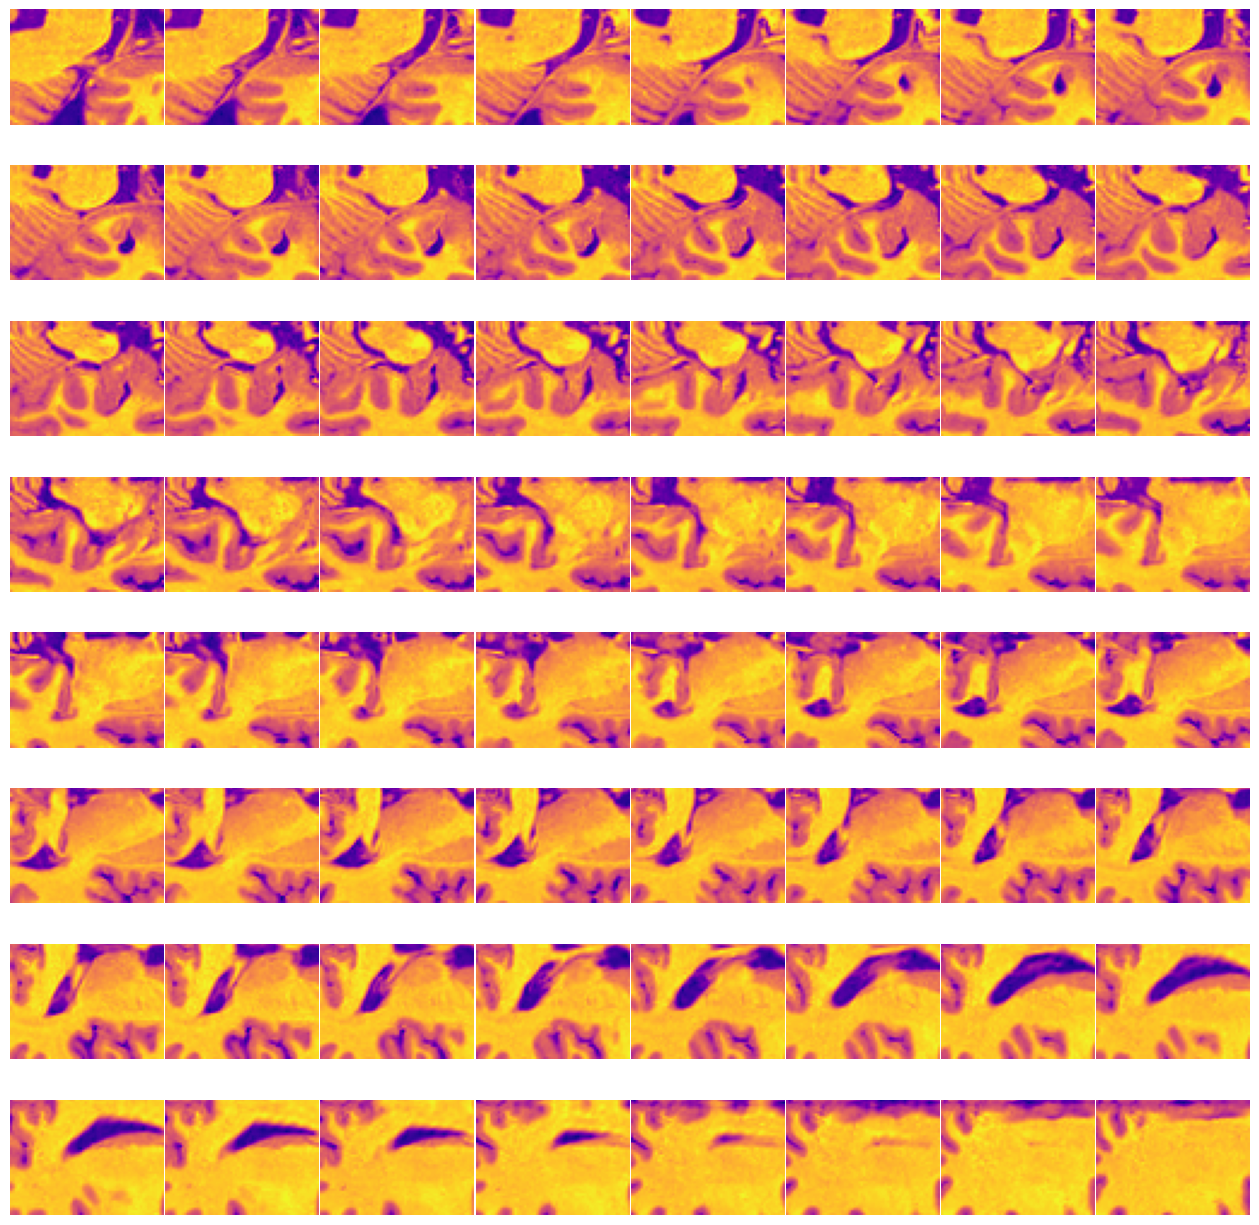

In [47]:
show_image(test_file)

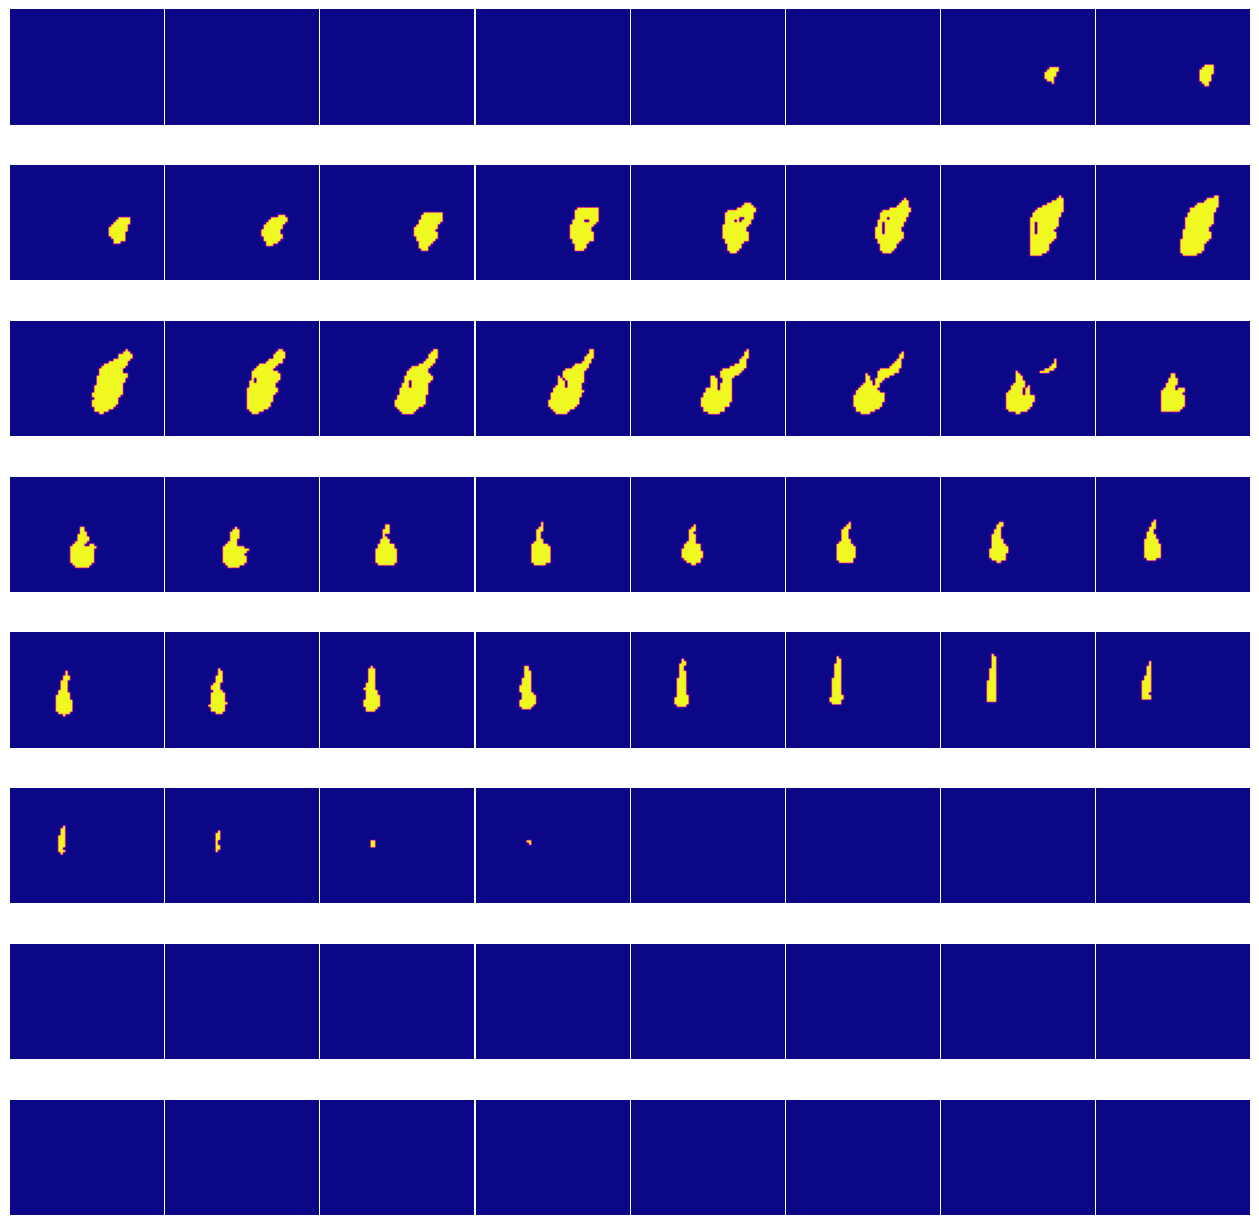

In [48]:
show_image(find_gt(test_file))

## Data Exploration

In [49]:
# List files in our data folder. 
files_df = pd.DataFrame()
files_df['file'] = files
files_df[['name','label','gt']] = pd.DataFrame(files_df.file.apply(lambda x: x.split('.')[0].split('_')).to_list())
files_df['gt'] = files_df['gt'].fillna(False).replace({'gt':True})

data_files_df = files_df[~files_df['gt']].drop(['gt'],axis=1).reset_index(drop=True).copy()
data_files_df['gt'] = data_files_df.file.apply(lambda x: find_gt(x))
data_files_df.head()

,file,name,label,gt
0,s08_R.nii.gz,s08,R,s08_R_gt.nii.gz
1,s23_L.nii.gz,s23,L,s23_L_gt.nii.gz
2,s25_R.nii.gz,s25,R,s25_R_gt.nii.gz
3,s02_R.nii.gz,s02,R,s02_R_gt.nii.gz
4,s02_L.nii.gz,s02,L,s02_L_gt.nii.gz


#### Data Insights *#Dryad*
1. Data is balanced. 
2. Total 25 images are there, with their **R** and **L** labeled images named as **s01 -> s25**. 
3. Each image has it's corresponding **gt**, i.e., `ground truth` images. 
4. It seems like data is clean and I did not find any noise or abnormal behaviour by a short manual inspection.

Hence, **no need of data preprocessing** .

In [50]:
data_files_df[data_files_df.name=='s10']

,file,name,label,gt
5,s10_R.nii.gz,s10,R,s10_R_gt.nii.gz
34,s10_L.nii.gz,s10,L,s10_L_gt.nii.gz


In [51]:
interact(explore_3dimage, Image='s08_R.nii.gz', Layer=(0, nii_data.shape[2] - 1))
interact(explore_3dimage, Image='s08_L.nii.gz', Layer=(0, nii_data.shape[2] - 1))

interactive(children=(Text(value='s08_R.nii.gz', description='Image'), IntSlider(value=31, description='Layer'…

interactive(children=(Text(value='s08_L.nii.gz', description='Image'), IntSlider(value=31, description='Layer'…

<function __main__.explore_3dimage(Image, Layer)>

## train-test Split

In [52]:
from sklearn.model_selection import train_test_split
VAL_SIZE = 5 #10% of total data
TEST_SIZE = 9 #20% of total data; 9 instead of 10 to make train 36 make it more divisible

In [53]:
train, validation =train_test_split(data_files_df, 
                                    test_size=VAL_SIZE, 
                                    shuffle=True,
                                    random_state=21,
                                    stratify=data_files_df.label)

train, test=train_test_split(train, 
                            test_size=TEST_SIZE, 
                            shuffle=True,
                            random_state=21,
                            stratify=train.label)

print(f'Shape of data\n|- train: {train.shape}\n|- validation: {validation.shape}\n|- test: {test.shape}')

Shape of data
|- train: (36, 4)
|- validation: (5, 4)
|- test: (9, 4)


In [54]:
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)
test = test.reset_index(drop=True)

train_list = list(train.iterrows())
validation_list = list(validation.iterrows())
test_list = list(test.iterrows())

Importing `Data Generator` and `Model`

# Implement a model for the segmentation task.

In [55]:
from data_generator import DataGenerator
from model import unet3D
from utils import *
from sklearn.metrics import classification_report
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryIoU
from keras.optimizers import Adam

# Control parameters
IMG_HEIGHT=48
IMG_WIDTH=64
IMG_DEPTH=64 
IMG_CHANNELS=1

EPOCHS = 5
BATCH_SIZE = 2
lr = 0.01

## Data Generators

In [56]:
params = {
        'data_path':data_path,
        'data_name':'Dryad',
        'dim':(48, 64),
        'bands':64,
        'n_classes':2
        }

train_generator = DataGenerator(train_list, batch_size=BATCH_SIZE, shuffle=True, **params)
validation_generator = DataGenerator(validation_list, batch_size=BATCH_SIZE, shuffle=True, **params)
test_generator = DataGenerator(test_list, batch_size=BATCH_SIZE, shuffle=False, **params)

X,y = train_generator.__getitem__(0)
print(f'Shape of generated data\n|- X: {X.shape}\n|- y: {y.shape}')

Shape of generated data
|- X: (2, 48, 64, 64, 1)
|- y: (2, 48, 64, 64, 1)


## Model

In [57]:
model = unet3D(IMG_HEIGHT=IMG_HEIGHT, 
               IMG_WIDTH=IMG_WIDTH, 
               IMG_DEPTH=IMG_DEPTH, 
               IMG_CHANNELS=IMG_CHANNELS)

print(f'Shape of model\'s architecture\n|- input: {model.input_shape}\n|- output: {model.output_shape}')

Shape of model's architecture
|- input: (None, 48, 64, 64, 1)
|- output: (None, 48, 64, 64, 1)


In [58]:
# loss = BinaryCrossentropy(from_logits=True)
loss = dice_coefficients_loss
optimizer = Adam(learning_rate=lr)
metrics = ["binary_accuracy", iou, dice_coefficients]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [59]:
%%time 
print(f'Training the {model._name} model.')
history = model.fit_generator(
                    generator=train_generator,
                    steps_per_epoch = len(train_list)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    workers=2,
                    use_multiprocessing=True,
                    verbose=1)

Training the 3D-UNET model.
Epoch 1/5


<timed exec>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
2023-09-18 12:19:49.476765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


18/18 [==============================] - ETA: 0s - loss: -0.0438 - binary_accuracy: 0.5752 - iou: 0.0227 - dice_coefficients: 0.0438

2023-09-18 12:20:11.019090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


18/18 [==============================] - 25s 1s/step - loss: -0.0438 - binary_accuracy: 0.5752 - iou: 0.0227 - dice_coefficients: 0.0438 - val_loss: -0.0432 - val_binary_accuracy: 0.5850 - val_iou: 0.0224 - val_dice_coefficients: 0.0432
Epoch 2/5
18/18 [==============================] - 24s 1s/step - loss: -0.0441 - binary_accuracy: 0.5627 - iou: 0.0228 - dice_coefficients: 0.0441 - val_loss: -0.0455 - val_binary_accuracy: 0.5539 - val_iou: 0.0235 - val_dice_coefficients: 0.0455
Epoch 3/5
18/18 [==============================] - 27s 1s/step - loss: -0.0443 - binary_accuracy: 0.5561 - iou: 0.0229 - dice_coefficients: 0.0443 - val_loss: -0.0468 - val_binary_accuracy: 0.5452 - val_iou: 0.0242 - val_dice_coefficients: 0.0468
Epoch 4/5
18/18 [==============================] - 25s 1s/step - loss: -0.0443 - binary_accuracy: 0.5550 - iou: 0.0229 - dice_coefficients: 0.0443 - val_loss: -0.0471 - val_binary_accuracy: 0.5436 - val_iou: 0.0244 - val_dice_coefficients: 0.0471
Epoch 5/5
18/18 [=====

## Performance Analysis

In [60]:
interact(plot_history, 
         history=fixed(history),
         epoch=EPOCHS,
         metric=['loss', 
                 'binary_accuracy', 
                 'iou', 
                 'dice_coefficients'
                ]
        )

interactive(children=(IntSlider(value=5, description='epoch', max=15, min=-5), Dropdown(description='metric', …

<function utils.plot_history(history, epoch, metric)>

# Extend your pipeline to create a flip-robust segmentation

In [61]:
# Control parameters
IMG_HEIGHT=48
IMG_WIDTH=64
IMG_DEPTH=64 
IMG_CHANNELS=1

EPOCHS = 5
BATCH_SIZE = 2
lr = 0.01

## Data Generators

In [62]:
params = {
        'data_path':data_path,
        'data_name':'Dryad',
        'dim':(48, 64),
        'bands':64,
        'n_classes':2,
        'augment':True,
        'augmentation_prob':0.5 # Probability threshold for horizental flip. 
        }

train_generator2 = DataGenerator(train_list, batch_size=BATCH_SIZE, shuffle=True, **params)
validation_generator2 = DataGenerator(validation_list, batch_size=BATCH_SIZE, shuffle=True, **params)
test_generator2 = DataGenerator(test_list, batch_size=BATCH_SIZE, shuffle=False, **params)

X,y = train_generator.__getitem__(0)
print(f'Shape of generated data\n|- X: {X.shape}\n|- y: {y.shape}')

Shape of generated data
|- X: (2, 48, 64, 64, 1)
|- y: (2, 48, 64, 64, 1)


## Model

In [63]:
model2 = unet3D(IMG_HEIGHT=IMG_HEIGHT, 
               IMG_WIDTH=IMG_WIDTH, 
               IMG_DEPTH=IMG_DEPTH, 
               IMG_CHANNELS=IMG_CHANNELS)

print(f'Shape of model\'s architecture\n|- input: {model2.input_shape}\n|- output: {model2.output_shape}')

Shape of model's architecture
|- input: (None, 48, 64, 64, 1)
|- output: (None, 48, 64, 64, 1)


In [64]:
loss = BinaryCrossentropy(from_logits=True)
# loss = dice_coefficients_loss
optimizer = Adam(learning_rate=lr)
metrics = ["binary_accuracy", iou, dice_coefficients]
model2.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
%%time 
print(f'Training the {model._name} model.')
history2 = model2.fit_generator(
                    generator=train_generator2,
                    steps_per_epoch = len(train_list)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_generator2,
                    workers=2,
                    use_multiprocessing=True,
                    verbose=1)

Training the 3D-UNET model.
Epoch 1/5


<timed exec>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
2023-09-18 12:21:57.580946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/home/omm/anaconda3/envs/daad-task/lib/python3.11/site-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


18/18 [==============================] - ETA: 0s - loss: 23119.5859 - binary_accuracy: 0.3733 - iou: 0.0227 - dice_coefficients: 0.0435

2023-09-18 12:22:22.377771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


18/18 [==============================] - 28s 1s/step - loss: 23119.5859 - binary_accuracy: 0.3733 - iou: 0.0227 - dice_coefficients: 0.0435 - val_loss: 0.4582 - val_binary_accuracy: 0.9646 - val_iou: 0.0053 - val_dice_coefficients: 0.0072
Epoch 2/5
18/18 [==============================] - 33s 2s/step - loss: 1.0305 - binary_accuracy: 0.9309 - iou: 0.0220 - dice_coefficients: 0.0418 - val_loss: 0.3761 - val_binary_accuracy: 0.9092 - val_iou: 0.0207 - val_dice_coefficients: 0.0396
Epoch 3/5
18/18 [==============================] - 30s 2s/step - loss: 0.2643 - binary_accuracy: 0.9583 - iou: 0.0197 - dice_coefficients: 0.0364 - val_loss: 0.2094 - val_binary_accuracy: 0.9523 - val_iou: 0.0171 - val_dice_coefficients: 0.0309
Epoch 4/5
15/18 [========================>.....] - ETA: 4s - loss: 0.2210 - binary_accuracy: 0.9650 - iou: 0.0199 - dice_coefficients: 0.0365

## Performance Analysis

In [ ]:
interact(plot_history, 
         history=fixed(history2),
         epoch=EPOCHS,
         metric=['loss', 
                 'binary_accuracy', 
                 'iou', 
                 'dice_coefficients'
                ]
        )

### Binary Crossentropy
The BCE loss can be mathematically defined as follows:

> BCE Loss = - [y * log(p) + (1 - y) * log(1 - p)]

where:
- y is the ground truth label (0 or 1).
- p is the predicted probability of the voxel being in the foreground (tumor) class.

The loss encourages the network to make predictions (p) that are close to the ground truth labels (y) for each voxel. It measures the dissimilarity between the predicted probabilities and true binary values.

For binary segmentation (e.g., tumor vs. non-tumor), we can use BCE loss, especially **if the task is to obtain pixel-wise probabilities**.

### Dice Coefficient Loss
The Dice coefficient (also known as the Sørensen–Dice coefficient) measures the spatial overlap between predicted and ground truth segmentation masks. It is defined as:

> Dice = (2 * |A ∩ B|) / (|A| + |B|)

where:
- A represents the predicted segmentation mask.
- B represents the ground truth segmentation mask.

|A ∩ B| is the number of overlapping voxels between A and B.
|A| and |B| are the total number of voxels in A and B, respectively.

The Dice coefficient loss encourages the network to produce segmentation masks that have high spatial overlap with the ground truth. This is particularly **useful in multi-class scenarios, as it ensures that the network's predictions align well with the actual anatomical structures**.

For multi-class segmentation where if I have more than two classes (e.g., tissue segmentation in MRI), Dice coefficient loss or variants like the soft Dice loss are often preferred. These loss functions tend to handle class imbalances better and encourage better spatial overlap between predicted and ground truth masks.

In [ ]:
predictions = model.predict_generator(test_generator)[:,:,:,:,-1]

In [ ]:
test_generator.__getitem__(0)[0][0]

In [ ]:
# Define a function to visualize the data
def explore_3dimage(Image, Layer):
    imageObj = nib.load(os.path.join(data_path,data_name,Image))
    gt_imageObj = nib.load(os.path.join(data_path,data_name,find_gt(Image)))
    image = imageObj.get_fdata()
    imageGT = gt_imageObj.get_fdata()
    
    plt.figure(figsize=(6, 3))
    plt.subplot(131)
    plt.imshow(image[:, :, Layer], cmap='plasma');
    plt.title(f'Explore Layers of {data_name}')
    plt.xlabel(Image)
    
    plt.subplot(132)
    plt.imshow(imageGT[:, :, Layer], cmap='plasma');
    plt.title('Ground Truth')
    plt.xlabel(find_gt(Image))
    
    plt.subplot(133)
    plt.imshow(imageGT[:, :, Layer], cmap='plasma');
    plt.title('Model Prediction')
    plt.xlabel(find_gt(Image))
    return
    
# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, Image=test_file, Layer=(0, nii_data.shape[2] - 1))

```python
# from keras import layers
from tensorflow.keras import layers
from keras.models import Model
import tensorflow as tf

# Defining 3D-Unet architecture
kernel_initializer = 'he_uniform' #Try others if you want
def down_block(input, kernels, drop_ratio=0):
    conv = layers.Conv3D(kernels, (3, 3, 2), activation='relu', kernel_initializer=kernel_initializer, padding='same')(input)
    d = layers.Dropout(drop_ratio)(conv)
    conv = layers.Conv3D(kernels, (3, 3, 2), activation='relu', kernel_initializer=kernel_initializer, padding='same')(d)
    p = layers.MaxPooling3D((2, 2, 2))(conv)
    #print(input.shape, p.shape)
    return (p,conv)

def up_block(input, kernels, drop_ratio, concat_layer):
    conv = layers.Conv3DTranspose(kernels, (2, 2, 2), strides=(2, 2, 2), padding='same')(input)
    concat = layers.concatenate([conv, concat_layer])
    conv = layers.Conv3D(kernels, (3, 3, 2), activation='relu', kernel_initializer=kernel_initializer, padding='same')(concat)
    d = layers.Dropout(drop_ratio)(conv)
    conv = layers.Conv3D(kernels, (3, 3, 2), activation='relu', kernel_initializer=kernel_initializer, padding='same')(d)
    #print(input.shape, conv.shape)
    return conv
  
def unet3D(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, augment=False, augment_type='horizontal_and_vertical'):
    inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    if augment:
        s = tf.keras.layers.RandomFlip(mode=augment_type, seed=21)(inputs)
    else:
        s = inputs
    # Contraction path
    (p1,c1) = down_block(s, 16, 0.1)
    (p2,c2) = down_block(p1, 32, 0.1)
    (p3,c3) = down_block(p2, 64, 0.2)
    #(p4,c4) = down_block(p3, 128, 0.2)
    
    c5 = layers.Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    # Expansive path 
    # c6 = up_block(c5, 128, 0.2, c4)
    c7 = up_block(c5, 64, 0.2, c3)
    c8 = up_block(c7, 32, 0.1, c2)
    c9 = up_block(c8, 16, 0.1, c1)

    output = layers.Conv3D(1, (1,1,1), activation='sigmoid')(c9)
#     output = layers.Lambda(lambda x: x[:,:,:,:,-1])(c10)

    model = Model(inputs=[inputs], outputs=[output], name='3D-UNET')
    
    # Compile model outside of this function to make it flexible. 
    return model
```

```python
import os
import numpy as np
import nibabel as nib
import keras
import random

class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 image_names,
                 data_path,
                 data_name='Dryad',
                 batch_size=2,
                 dim=(58,64),
                 bands=64,
                 n_classes=2,
                 shuffle=True,
                 augment=False,
                 augmentation_prob=0.5
                ):        
        self.image_names = image_names
        self.data_path = data_path
        self.data_name = data_name
        self.batch_size = batch_size
        self.dim = dim
        self.bands = bands
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment=False,
        self.augmentation_prob=0.5
        self.on_epoch_end()
        
    # Denotes the number of batches per epoch
    def __len__(self):
        return int(np.floor(len(self.image_names) / self.batch_size))

    # Updates indexes after each epoch
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_names))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    # Generate one batch of data
    # Generate indexes of the batch
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        batch_images = [self.image_names[k][1] for k in indexes]
        # Generate data
        X, y = self.__data_generation(batch_images)
        return X, y

    # Generates data containing batch_size samples 
    # X : (n_samples, *patch, bands)       
    def __data_generation(self, batch_images):
        X = np.empty((self.batch_size, *self.dim, self.bands))
        y = np.empty((self.batch_size, *self.dim, self.bands))
        for i,image_path in enumerate(batch_images):
            # Load image
#             print(image_path)
            imageObj = nib.load(os.path.join(self.data_path,self.data_name,image_path.file))
            image = imageObj.get_fdata()
            # image = image[:,:,0:self.bands]
            
            # Load annotation data
            annotationObj = nib.load(os.path.join(self.data_path,self.data_name,image_path['gt']))
            annotation = annotationObj.get_fdata()
            
            # Apply data augmentation if augmentation is enabled
            if self.augment:
                if random.random() < self.augmentation_prob:
                    image = np.fliplr(image)  # Horizontal flip with augmentation_prob probability
                    annotation = np.fliplr(annotation)
                else:
                    image = np.flipud(image)  # Vertical flip with augmentation_prob probability
                    annotation = np.flipud(annotation)
            X[i] = image
            y[i] = annotation
            
        X = X.reshape(-1, *self.dim, self.bands, 1).copy()
        y = y.reshape(-1, *self.dim, self.bands, 1).copy()
        return X,y 
```

## References

1. Visualization: https://github.com/vb100/Visualize-3D-MRI-Scans-Brain-case/blob/master/playground.ipynb
2. Segmentation of Brain Tumors from MRI using Deep Learning: https://www.youtube.com/watch?v=PcNqAVNCZrE&t=1480s
3. Loss function: https://www.youtube.com/watch?v=X1q993i7Gic&t=1798s
